In [52]:
# using GuSTO
include("../src/GuSTO.jl")
using AstrobeeRobot
using Plots

In [53]:
robot = Freeflyer()
model = FreeflyerSE2()

FreeflyerSE2(6, 3, 0.05, Any[], Any[], Any[])

In [54]:
function setUpEnvironment()
    env = Table(:stanford);
    centers = Vector()
    push!(centers, [0.460; 0.315; 0.0])
    push!(centers, [0.201; 1.085; 0.0])
    push!(centers, [0.540; 2.020; 0.0])
    push!(centers, [1.374; 0.196; 0.0])
    push!(centers, [1.063; 1.354; 0.0])
    push!(centers, [1.365; 2.322; 0.0])
    push!(centers, [2.221; 0.548; 0.0])
    push!(centers, [2.077; 1.443; 0.0])
    push!(centers, [3.098; 1.186; 0.0])
    push!(centers, [2.837; 2.064; 0.0])
    # push!(centers, [1.500; 1.500; 0.0])

    widths = [0.27; 0.27; 0.127]
    inflation = 0.05*ones(3)

    for idx in 1:length(centers)
        push!(env.obstacle_set, HyperRectangle(Vec3f0(centers[idx]-0.5*widths-inflation+[0.;0.;0.5*widths[1]]), Vec3f0(widths+2*inflation)))
    end
    return env
end

setUpEnvironment (generic function with 1 method)

In [55]:
# Create obstacle grid representation using centers, widths, and inflation


In [56]:
# Set up problem, initial goal and final goal
function setUpProblem(N, x_init, x_goal)
    tf_guess = 200.
    goal_set = GoalSet()
    add_goal!(goal_set, Goal(PointGoal(x_goal), tf_guess, model))
    PD = ProblemDefinition(robot, model, env, x_init, goal_set)
    TOP = TrajectoryOptimizationProblem(PD, N, tf_guess, fixed_final_time=true)
    TOSgusto = TrajectoryOptimizationSolution(TOP)
    return TOP, TOSgusto
end


setUpProblem (generic function with 1 method)

In [57]:
function plotVelocity(TOSgusto, N)
    gr(fmt=:png)
    plot()
    plot!([collect(1:N)],[sqrt.(TOSgusto.SCPS.traj.X[4,:].^2 + TOSgusto.SCPS.traj.X[5,:].^2)],
        xlabel = "t",
        ylabel = "v",
        legend = :none)
    plot!()
end

plotVelocity (generic function with 1 method)

In [58]:
#### Code for animating free-flyer trajectories
function visualizeTraj(env, TOSgusto)
    vis = Visualizer()
    delete!(vis)

    vis[:goal]
    setobject!(vis[:goal][:goal], 
        Object(HyperSphere(Point3(x_goal[1:2]..., robot.r), 0.1),
            MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))

    vis[:table]
    table_dim = env.worldAABBmax-env.worldAABBmin
    setobject!(vis[:table][:table], 
            Object(HyperRectangle(env.worldAABBmin..., table_dim...),
                MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))

    vis[:obstacles]
    for (idx,obs) in enumerate(env.obstacle_set)
        setobject!(vis[:obstacles][Symbol(string("obs",idx))], 
            Object(obs,MeshBasicMaterial(color=RGBA(1.0,0.,0.,0.3))))
    end

    vis[:robot]

    setobject!(vis[:robot][:base],
        Object(Cylinder(Point3f0(0,0,0.),Point3f0(0.,0.,0.5),Float32(robot.r)),MeshBasicMaterial(color=RGBA(0,0.,1.,0.7))))

    up = [0;0;1.]
    q0 = vec2quat(up,x_init[3])
    Qs = Vector{Vector{Float64}}()

    speed_factor = 10

    for k in 1:speed_factor:N
        q = [quat_inv(quat_multiply(mrp2quat([0.; 0.; tan(TOSgusto.SCPS.traj.X[3,k]/4)]), q0)); [TOSgusto.SCPS.traj.X[1:2,k]; robot.r]]
        push!(Qs,q)
    end

    anim = MeshCat.Animation()
    for k in 1:N
        atframe(anim, vis, 5*k) do frame
            settransform!(frame[:robot], Translation(TOSgusto.traj.X[1,k], 
                TOSgusto.traj.X[2,k], TOSgusto.traj.X[3,k]))
        end
    end
    setanimation!(vis, anim)

    # plot_in_cell = true
    plot_in_cell = false
    plot_in_cell ? IJuliaCell(vis) : open(vis)
end

visualizeTraj (generic function with 1 method)

In [16]:
# Violates constraints start point
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
# Solve full solution with IPOPT
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=100, print_level=0);


In [17]:
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).iterations = 6
(TOSgusto.SCPS).converged = true
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0, 200.0, 2000.0, 20000.0, 200000.0, 2.0e6]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]


7-element Array{Float64,1}:
 4.0
 4.0
 4.0
 4.0
 4.0
 4.0
 4.0

In [59]:
# Violates constraints start point
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
if isdefined(TOSgusto, :SCPS)
    println("Before first, TOSgusto.SCPS defined")
else
    println("Before first, TOSgusto.SCPS NOT defined")
end
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=1, print_level=0);
# @show typeof(TOSgusto.SCPS.SCPP.param.alg)
iterCount = 1
if isdefined(TOSgusto.SCPS.param, :alg)
    println("After first, TOSgusto.SCPS.param.alg defined")
else
    println("After first, TOSgusto.SCPS.param.alg NOT defined")
end
while !TOSgusto.SCPS.converged && iterCount <=15
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    iterCount = iterCount + 1
    @show iterCount 
    @show TOSgusto.SCPS.param.alg.ω_vec
    @show TOSgusto.SCPS.param.alg.Δ_vec
end
println("Finished!")
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

Before first, TOSgusto.SCPS NOT defined
param.alg NOT defined
After first, TOSgusto.SCPS.param.alg defined
Inside solve_SCP SCPP.param.alg defined
Inside solve_SCP SCPS.param.alg defined
param.alg defined
iterCount = 2
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0, 200.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0, 4.0]
Inside solve_SCP SCPP.param.alg defined
Inside solve_SCP SCPS.param.alg defined
param.alg defined
iterCount = 3
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0, 200.0, 2000.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0, 4.0, 4.0]
Inside solve_SCP SCPP.param.alg defined
Inside solve_SCP SCPS.param.alg defined
param.alg defined
iterCount = 4
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0, 200.0, 2000.0, 20000.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0, 4.0, 4.0, 4.0]
Inside solve_SCP SCPP.param.alg defined
Inside solve_SCP SCPS.param.alg defined
param.alg defined
iterCount = 5
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0, 200.0, 2000.0, 20000.0

7-element Array{Float64,1}:
 4.0
 4.0
 4.0
 4.0
 4.0
 4.0
 4.0

In [18]:
# OK start point
env = setUpEnvironment()
N = 20
x_init = [0.2; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
# Solve full solution with IPOPT
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=100, print_level=0);


In [19]:
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).iterations = 8
(TOSgusto.SCPS).converged = true
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]


9-element Array{Float64,1}:
 4.0
 4.0
 4.0
 4.0
 4.0
 4.0
 4.0
 4.0
 4.0

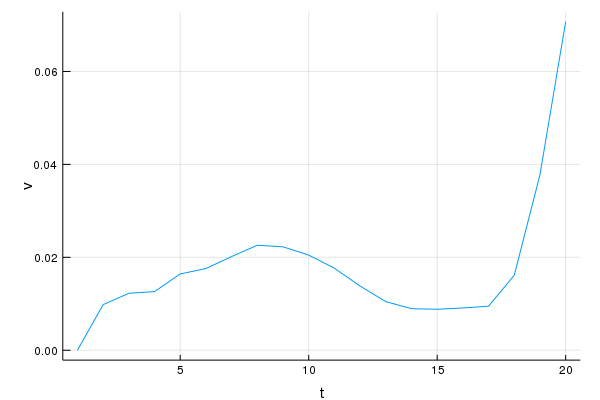

In [64]:
plotVelocity(TOSgusto, N)

In [65]:
visualizeTraj(env, TOSgusto)

┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8701
└ @ MeshCat /home/somrita/.julia/packages/MeshCat/WlA0B/src/servers.jl:24


Process(`xdg-open http://127.0.0.1:8701`, ProcessExited(0))

[15132:15144:0509/164725.644705:ERROR:browser_process_sub_thread.cc(217)] Waited 9 ms for network service


Opening in existing browser session.


In [70]:
# Solve full solution with Gurobi
env = setUpEnvironment()
N = 20
x_init = [0.4; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", max_iter=100, OutputFlag=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.accept_solution
# visualizeTraj(env, TOSgusto)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).iterations = 6
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true, true, true, true]


7-element Array{Bool,1}:
 true
 true
 true
 true
 true
 true
 true

In [13]:
# Create loop to run SCP one iteration at a time and store off TOSgusto.SCPS.traj as well as parameters
first_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=1, print_level=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.traj.U
@show TOSgusto.SCPS.traj.Tf
@show TOSgusto.SCPS.traj.dt
@show TOSgusto.SCPS.iterations


# @show TOSgusto.SCPS.converged
# @show TOSgusto.SCPS.dual


(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0]
((TOSgusto.SCPS).traj).X = [0.2 0.35596 0.686916 0.93169 0.982068 0.941173 0.938362 1.02586 1.21312 1.46162 1.68531 1.84353 1.98258 2.14922 2.33303 2.49448 2.59091 2.61269 2.67234 3.0; 2.4 2.421 2.41076 2.28003 2.07583 1.91678 1.87579 1.93 1.93 1.71858 1.35014 1.04793 0.934157 0.938762 0.95229 0.938762 0.910583 0.89013 0.824005 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0296324 0.0332493 0.0132577 -0.00368597 -0.004084 0.00354994 0.0130748 0.0225044 0.0247101 0.0177915 0.0122696 0.0141501 0.0175122 0.0174126 0.0132619 0.00506002 -0.000921716 0.0122553 0.05; 0.0 0.00398951 -0.00593426 -0.0189047 -0.0198931 -0.010326 0.00253762 0.00776191 -0.0077619 -0.0324079 -0.0375962 -0.0198228 -0.00179453 0.0026695 -9.92307e-5 -0.002471 -0.00288311 -0.00100284 -0.011561 -0.05; 0.0 0.0 0.0 0.0

In [17]:
second_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.traj.U
@show TOSgusto.SCPS.traj.Tf
@show TOSgusto.SCPS.traj.dt
@show TOSgusto.SCPS.iterations


(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0]
((TOSgusto.SCPS).traj).X = [0.2 0.299676 0.536763 0.778069 0.928809 1.0019 1.0772 1.20638 1.38087 1.55698 1.68531 1.74225 1.74582 1.73889 1.76503 1.85327 2.01215 2.24022 2.55412 3.0; 2.4 2.42819 2.46389 2.41264 2.24251 2.02948 1.88249 1.86241 1.93 1.89076 1.57423 1.11621 0.804182 0.735748 0.818839 0.938762 1.0241 1.02808 0.883608 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0189383 0.0261082 0.01974 0.00890054 0.00498663 0.00932009 0.015225 0.0179269 0.0155355 0.00884622 0.0019729 -0.00129537 -2.03984e-5 0.00498651 0.0117787 0.0184094 0.0249237 0.034717 0.05; 0.0 0.00535535 0.00142908 -0.0111678 -0.0211568 -0.0193175 -0.00861116 0.00479611 0.00804561 -0.0155009 -0.0446395 -0.0423847 -0.0169009 0.00389838 0.0118888 0.0108966 0.00531809 -0.00456337 -0.0228854 -0.05; 0.0 0.0 0.0 0.0 

1

In [19]:
for i in 1:20
    next_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    @show TOSgusto.SCPS.scp_status
    @show TOSgusto.SCPS.param.alg.ω_vec
    @show TOSgusto.SCPS.param.alg.Δ_vec
    @show TOSgusto.SCPS.traj.X
    @show TOSgusto.SCPS.traj.U
    @show TOSgusto.SCPS.traj.Tf
    @show TOSgusto.SCPS.traj.dt
    @show TOSgusto.SCPS.iterations
end

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0]
((TOSgusto.SCPS).traj).X = [0.2 0.296399 0.529842 0.774272 0.928537 1.00033 1.07861 1.21684 1.39493 1.56503 1.68531 1.74216 1.75674 1.76243 1.78737 1.856 1.99115 2.21325 2.54264 3.0; 2.4 2.42448 2.45456 2.40478 2.24265 2.03515 1.88817 1.86585 1.93 1.89076 1.58036 1.11633 0.767169 0.646967 0.704168 0.846237 0.982345 1.02423 0.88695 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0183159 0.0260383 0.0204034 0.00890702 0.00473418 0.0101389 0.0161254 0.0177103 0.0146085 0.00824542 0.00255531 0.000216286 0.000865055 0.00387362 0.00916574 0.0165128 0.025686 0.036898 0.05; 0.0 0.00465105 0.0010635 -0.01052 -0.0202856 -0.0191387 -0.00878826 0.00454664 0.00764277 -0.015098 -0.043879 -0.0442865 -0.0220537 -0.000784648 0.0116529 0.0153401 0.0105204 -0.0025626 -0.0235204 -0.05; 0.0 0.0 0.0 0.0 0

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0]
((TOSgusto.SCPS).traj).X = [0.2 0.29624 0.529601 0.773493 0.924245 0.990202 1.06587 1.20695 1.38991 1.56361 1.68531 1.74216 1.75685 1.76348 1.78974 1.8593 1.99448 2.21557 2.54342 3.0; 2.4 2.4209 2.44737 2.40499 2.25765 2.05708 1.9039 1.87128 1.93 1.89076 1.58132 1.11633 0.764592 0.641471 0.696644 0.838582 0.97661 1.02133 0.886215 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0182857 0.0260527 0.0202868 0.00835608 0.00417583 0.0102003 0.0166064 0.0181553 0.0148471 0.0082764 0.00252434 0.00026731 0.000992562 0.00399766 0.00921875 0.0164644 0.025543 0.0367494 0.05; 0.0 0.00397042 0.0010592 -0.00911204 -0.0188821 -0.0192255 -0.00987806 0.00367951 0.00747719 -0.0149324 -0.0438623 -0.0444854 -0.0223443 -0.00104871 0.0115315 0.0154367 0.0107886 -0.00229139 -0.0233808 -0.05; 0.0 0.0 0.0 0.

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0]
((TOSgusto.SCPS).traj).X = [0.2 0.29624 0.529601 0.773493 0.924245 0.990202 1.06587 1.20695 1.38991 1.56361 1.68531 1.74216 1.75685 1.76348 1.78974 1.8593 1.99448 2.21557 2.54342 3.0; 2.4 2.4209 2.44737 2.40499 2.25765 2.05708 1.9039 1.87128 1.93 1.89076 1.58132 1.11633 0.764592 0.641471 0.696644 0.838582 0.97661 1.02133 0.886215 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0182857 0.0260527 0.0202868 0.00835605 0.0041758 0.0102003 0.0166064 0.0181553 0.0148472 0.00827641 0.00252434 0.000267309 0.000992561 0.00399766 0.00921876 0.0164644 0.025543 0.0367494 0.05; 0.0 0.0039704 0.00105919 -0.00911202 -0.0188821 -0.0192255 -0.00987809 0.00367949 0.0074772 -0.0149324 -0.0438623 -0.0444854 -0.0223443 -0.0010487 0.0115315 0.0154367 0.0107886 -0.0022914 -0.0233809 -0.05; 0.0 0.0 0.0 0.0 

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0]
((TOSgusto.SCPS).traj).X = [0.2 0.29624 0.529601 0.773493 0.924245 0.990202 1.06587 1.20695 1.38991 1.56361 1.68531 1.74216 1.75685 1.76348 1.78974 1.8593 1.99448 2.21557 2.54342 3.0; 2.4 2.4209 2.44737 2.40499 2.25765 2.05708 1.9039 1.87128 1.93 1.89076 1.58132 1.11633 0.764593 0.641472 0.696644 0.838582 0.97661 1.02133 0.886215 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0182857 0.0260527 0.0202868 0.00835608 0.00417583 0.0102003 0.0166064 0.0181553 0.0148471 0.00827639 0.00252434 0.000267315 0.000992572 0.00399766 0.00921876 0.0164644 0.025543 0.0367494 0.05; 0.0 0.00397043 0.0010592 -0.00911206 -0.0188821 -0.0192255 -0.00987804 0.00367953 0.0074772 -0.0149324 -0.0438623 -0.0444854 -0.0223443 -0.00104871 0.0115315 0.0154367 0.0107886 -0.00229139 -0.0233808 -0.05; 0.0 0.0 0.0 0

In [21]:
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=100, print_level=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.traj.U
@show TOSgusto.SCPS.traj.Tf
@show TOSgusto.SCPS.traj.dt
@show TOSgusto.SCPS.iterations

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0, 200.0, 2000.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0, 4.0, 4.0]
((TOSgusto.SCPS).traj).X = [0.2 0.29624 0.529601 0.773493 0.924245 0.990203 1.06587 1.20695 1.38991 1.56361 1.68531 1.74216 1.75685 1.76348 1.78974 1.8593 1.99448 2.21557 2.54342 3.0; 2.4 2.4209 2.44737 2.40499 2.25765 2.05708 1.9039 1.87128 1.93 1.89076 1.58132 1.11633 0.764593 0.641472 0.696644 0.838582 0.97661 1.02133 0.886215 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0182857 0.0260527 0.0202868 0.0083561 0.00417586 0.0102003 0.0166063 0.0181553 0.0148471 0.00827639 0.00252434 0.000267317 0.000992569 0.00399766 0.00921876 0.0164644 0.025543 0.0367494 0.05; 0.0 0.00397044 0.00105919 -0.00911211 -0.0188822 -0.0192255 -0.00987801 0.00367957 0.00747722 -0.0149324 -0.0438623 -0.0444854 -0.0223443 -0.0010487 0.01

3

In [18]:
include("../ok.jl")

Randomness

In [ ]:
# @show TOSgusto.SCPS.param.alg.ω_vec
function ok()
    print("thiss2")
end
ok()

In [13]:
SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
@show TOSgusto.SCPS.dual
@show TOSgusto.SCPS.traj
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

(TOSgusto.SCPS).dual = [1.18585, 0.0792019, 0.0, 3.04974, 0.78768, 0.0]
(TOSgusto.SCPS).traj = Trajectory([0.2 0.356809 0.681854 0.908889 0.961339 0.985315 1.09604 1.26675 1.42619 1.53796 1.61666 1.70477 1.83012 1.98604 2.14286 2.26937 2.35538 2.43718 2.61106 3.0; 2.4 2.41609 2.41076 2.30491 2.11842 1.94558 1.83199 1.74662 1.64222 1.4984 1.33033 1.17263 1.05435 0.988327 0.976585 1.01234 1.0628 1.05503 0.894058 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0297938 0.0319647 0.011172 -0.00120646 0.00576185 0.0152758 0.017159 0.0131355 0.00809958 0.00685299 0.00988849 0.0139288 0.0156965 0.0140992 0.00993755 0.00640456 0.00913757 0.0238987 0.05; 0.0 0.00305751 -0.00407025 -0.0160419 -0.0193914 -0.0134472 -0.00813502 -0.00808526 -0.0117513 -0.0155747 -0.0163573 -0.0136071 -0.00886632 -0.00367721 0.00144614 0.00534725 0.00423951 -0.00571436 -0.024871 -0.05; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0], [0.0619

Trajectory

In [6]:
# using Profile
# using ProfileView 
# Profile.clear()
# @profile solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", OutputFlag=0)
# ProfileView.view()

In [22]:
SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", OutputFlag=0);
# SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", print_level=0);


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [23]:
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.total_time
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.convergence_measure
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.J_true
@show TOSgusto.SCPS.dual
;

(TOSgusto.SCPS).converged = true
(TOSgusto.SCPS).iterations = 6
(TOSgusto.SCPS).total_time = 6.451426258000001
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true, true, true, true]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).convergence_measure = [0.0, 0.121476, 0.0849042, 0.0464864, 0.0146997, 0.00463386, 0.00146759]
(((TOSgusto.SCPS).param).alg).ω_vec = [2.0, 20.0, 200.0, 2000.0, 20000.0, 200000.0, 2.0e6]
(((TOSgusto.SCPS).param).alg).Δ_vec = [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
(TOSgusto.SCPS).J_true = Any[0.0, 0.253129, 0.29253, 0.230932, 0.208509, 0.203066, 0.201448]
(TOSgusto.SCPS).dual = [NaN, NaN, NaN, NaN, NaN, NaN]


┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8700
└ @ MeshCat /home/somrita/.julia/packages/MeshCat/WlA0B/src/servers.jl:24


Process(`xdg-open http://127.0.0.1:8700`, ProcessExited(0))

Opening in existing browser session.


In [11]:
@show TOSgusto.SCPS.traj


(TOSgusto.SCPS).traj = Trajectory([0.2 0.201861 0.20669 0.213193 0.220707 0.229091 0.238307 0.248317 0.259084 0.27057 0.282736 0.295545 0.308958 0.322938 0.337448 0.352448 0.367901 0.383769 0.400015 0.416599 0.433486 0.450635 0.46801 0.485573 0.503285 0.521109 0.539007 0.556941 0.574872 0.592764 0.610578 0.628276 0.64582 0.663173 0.680296 0.697151 0.713701 0.729908 0.745733 0.761139 0.776088 0.790543 0.804464 0.817814 0.830555 0.842651 0.854073 0.8648 0.87482 0.884123 0.892712 0.900602 0.907824 0.91442 0.920448 0.925975 0.931074 0.935815 0.940269 0.944507 0.948601 0.95262 0.956636 0.96072 0.964942 0.969375 0.974089 0.979152 0.98463 0.990576 0.997039 1.00406 1.01166 1.01984 1.02857 1.03781 1.04754 1.05773 1.06834 1.07934 1.09071 1.10241 1.11441 1.12668 1.13918 1.1519 1.16479 1.17783 1.19098 1.20421 1.2175 1.23081 1.24411 1.25736 1.27055 1.28364 1.29659 1.30937 1.32196 1.33433 1.34643 1.35825 1.36975 1.3809 1.39167 1.40202 1.41195 1.42147 1.43057 1.43929 1.44765 1.45566 1.46334 1.47071 1

Trajectory([0.2 0.201861 … 2.95056 3.0; 2.4 2.40014 … 0.548898 0.5; … ; 0.0 0.000281264 … -0.0473063 -0.05; 0.0 -7.5365e-10 … -7.41985e-9 0.0], [0.0722958 0.0509128 … 0.0266829 0.0273053; 0.00476795 0.00459049 … -0.0446385 -0.0449888; -1.36909e-10 -1.39048e-10 … 1.20121e-9 1.51581e-9], 200.0, 1.0050251256281406)

In [2]:
typeof(TOSgusto.SCPS.traj)


UndefVarError: UndefVarError: TOSgusto not defined